The point of this notebook is to provide a relatively user-friendly interface for finding passages related to a given passage, via comparison of their OpenAI vector embeddings. I presume that the texts have already been loaded into the Tesserae database and vectorized, following the scripts in the Maximus-bioinformatics notebook. 

In [35]:
from bson import ObjectId
import pandas as pd
from tesserae.db import TessMongoConnection
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

connection = TessMongoConnection('127.0.0.1', 27017, None, None, db='maximus')

def load_vectors_from_mongodb(title,unit_type='line'):
    text_id = connection.find('texts',title=title)[0].id
    vectors = pd.DataFrame(connection.aggregate('vectors',[{'$match': {'text': text_id, 'unit_type': unit_type}}, 
                                               {"$project": {"_id": 0, "index": 1, "tags": {"$arrayElemAt": ["$tags", 0]}, "unit_type": 1, "vector": 1}}],
                                              encode=False))
    vectors['title'] = title
    data = np.array([np.array(vector) for vector in vectors['vector']])
    metadata = vectors.T.drop('vector').T
    return data, metadata

def fit_and_transform_pca(data, n_components=50):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(data)

def find_related(passage,title,unit_type='line',n_components=500,N=15,plot=False):
    if 'phrase' not in passage.keys():
        passage['phrase']=0

    #Load source and target data
    data_s, metadata_s = load_vectors_from_mongodb(passage['title'],unit_type=passage['unit_type'])
    data_t, metadata_t = load_vectors_from_mongodb(title,unit_type=unit_type)
    data = np.vstack((data_s,data_t))

    #Find text id's
    text_s = connection.find('texts',title=passage['title'])[0].id
    text_t = connection.find('texts',title=title)[0].id

    #Reduce to relevant dimensions using PCA
    pca_result = fit_and_transform_pca(data,n_components=n_components)
    pca_result = (pca_result.T/np.linalg.norm(pca_result,axis=1)).T
    N_s = len(data_s)
    data_s = pca_result[:N_s]
    data_t = pca_result[N_s:]

    #Find the text of the source passage and its index, then compute distances
    content = connection.find('units',tags=passage['tag'],text=text_s,unit_type=passage['unit_type'])[passage['phrase']]
    idx = metadata_s.loc[metadata_s['index']==content.index].index[0]
    metadata_t['distance'] = data_t.dot(data_s[idx,:])

    #Plot all distances for reference
    if plot:
        plt.hist(metadata_t['distance'],bins=100)
        plt.show()

    print('Source passage:')
    print(content.snippet)
    print('-----------------')
    print('-----------------')

    #Sort by distance and print
    metadata_sorted = metadata_t.sort_values('distance',ascending=False)
    k = 0
    while k <= N:
        idx_k = metadata_sorted['index'].iloc[k]
        tag_k = metadata_sorted['tags'].iloc[k]
        dist_k = metadata_sorted['distance'].iloc[k]
        text_k = connection.find('units',index=idx_k,text=text_t,unit_type=unit_type)[0].snippet
    
        print(str(k)+'. '+title+' '+tag_k+', distance = '+str(dist_k))
        print(text_k)
        print('-----------------')
        k+=1

    return metadata_sorted

In [42]:
title_id = connection.find('texts',title='Quaestiones ad Thalassium')[0].id
content = connection.find('units',tags='prol.1',text=title_id,unit_type='phrase')[0]
content.snippet

'Φυσικὸν μὲν τοῖς λογικοῖς πέφυκε κάλλος ὁ λόγος· λόγου δὲ κάλλος ἡ κατὰ τὸν λόγον ἀκριβὴς τῶν λογικῶν ἐστι σύνεσις· συνέσεως δὲ κάλλος ἐστὶν ἡ κατὰ τὴν ἀρετὴν σὺν λόγῳ τῶν λογικῶν γόνιμος ἕξις· ταύτης δὲ κάλλος τῆς ἕξεως ἡ περὶ τὴν ἀληθῆ γνῶσιν ἀπλανὴς θεωρία καθέστηκεν, ἧς τέλος ἐστὶν ἡ σοφία, συνέσεως ὑπάρχουσα σαφεστάτη συμπλήρωσις, οἷα δὴ λόγος τυγχάνουσα κατὰ φύσιν τετελεσμένος, ὅστις ἐστὶ νοῦς καθαρός, τῇ περὶ τὴν αἰτίαν ἑνώσει σχέσιν λαβὼν ὑπὲρ νόησιν· καθ᾽ ἥν, ἀποπαύσας τὴν πολυποίκιλον πρὸς τὰ μετὰ τὴν αἰτίαν φυσικὴν αὐτοῦ κίνησίν τε καὶ σχέσιν, μόνης ἀγνώστως ἀντέχεται, κατὰ τὴν ἄφθεγκτον λῆξιν γεγενημένος, τῆς ὑπὲρ νόησιν παμμακαρίστου σιγῆς, ἣν δηλῶσαι παντελῶς οὐ δύναται λόγος ἢ νόησις, ἀλλὰ μόνη κατὰ τὴν μέθεξιν ἡ πεῖρα τῶν ἀξιωθέντων τῆς ὑπὲρ νόησιν ἀπολαύσεως, ἧς σημεῖόν ἐστιν εὔγνωστόν τε καὶ πᾶσι κατάδηλον ἡ κατὰ διάθεσιν πρὸς τὸν αἰῶνα τοῦτον παντελὴς ἀναισθησία τῆς ψυχῆς καὶ διάστασις.'

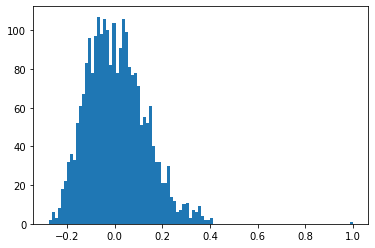

Source passage:
Πλὴν καλὰ γίνεται καὶ τὰ πάθη ἐν τοῖς σπουδαίοις, ὁπηνίκα σοφῶς αὐτὰ τῶν σωματικῶν ἀποστήσαντες, πρὸς τὴν τῶν οὐρανίων μεταχειρίζονται κτῆσιν· οἷον, τὴν μὲν ἐπιθυμίαν τῆς νοερᾶς τῶν θείων ἐφέσεως ὀρεκτικὴν ἐργάσονται κίνησιν, τὴν ἡδονὴν δὲ τῆς ἐπὶ τοῖς θείοις χαρίσμασι τοῦ νοῦ θελκτικῆς ἐνεργείας εὐφροσύνην ἀπήμονα, τὸν δὲ φόβον τῆς μελλούσης ἐπὶ πλημμελήμασι τιμωρίας προφυλακτικὴν ἐπιμέλειαν, τὴν δὲ λύπην διορθωτικὴν ἐπὶ παρόντι κακῷ μεταμέλειαν, καὶ συντόμως  εἰπεῖν, κατὰ τοὺς σοφοὺς τῶν ἰατρῶν, σώματι φθαρτικοῦ θηρὸς τῆς ἐχίδνης τὴν οὖσαν ἢ μελετωμένην ἀφαιρουμένους λώβωσιν, τοῖς  πάθεσι τούτοις πρὸς ἀναίρεσιν χρώμενοι παρούσης κακίας ἢ προσδοκωμένης, καὶ κτῆσιν καὶ φυλακὴν ἀρετῆς τε καὶ γνώσεως.
-----------------
-----------------
0. Quaestiones ad Thalassium 1.5, distance = 1.0000000000000004
Πλὴν καλὰ γίνεται καὶ τὰ πάθη ἐν τοῖς σπουδαίοις, ὁπηνίκα σοφῶς αὐτὰ τῶν σωματικῶν ἀποστήσαντες, πρὸς τὴν τῶν οὐρανίων μεταχειρίζονται κτῆσιν· οἷον, τὴν μὲν ἐπιθυμίαν τῆς νοερ

6. Quaestiones ad Thalassium 64.14, distance = 0.3792426604410621
Εἰ δὲ πρὸς τὴν τοῦ καθ᾽ ἕκαστον θεωρίαν τὴν Νινευὴ νοοῦμεν, τὴν ἑκάστου ψυχὴν εἶναί φαμεν τὴν πόλιν  τὴν μεγάλην, πρὸς ἣν ἀποστέλλεται παρανομοῦσαν ὁ τοῦ Θεοῦ Λόγος, κηρύξων μετάνοιαν πρὸς ζωήν· ταύτης δὲ βασιλέα νοοῦμεν τὸν νοῦν, ἄρχοντας δὲ τὰς ἐμφύτους δυνάμεις, ἀνθρώπους δὲ τοὺς ἐμπαθεῖς λογισμούς, κτήνη δὲ τὰ περὶ τὸ σῶμα κατ᾽ ἐπιθυμίαν κινήματα, βόας δὲ τὰς κατὰ τὸν θυμὸν περὶ τὰ ὑλικὰ πλεονεκτικὰς κινήσεις, πρόβατα δὲ τὰ κατὰ τὴν αἴσθησιν χωρὶς διανοίας ἀντιληπτικὰ τῶν αἰσθητῶν κινήματα, καὶ τὸν μὲν βασιλέα νοῦν, ὡς ἀπὸ θρόνου τινός, τῆς κατὰ τὴν προτέραν ἄγνοιαν ἐξανιστάμενον ἕξεως καί, ὥσπερ στολήν, τὴν ψευδῆ περὶ τῶν ὄντων δόξαν ἀποτιθέμενον καί, ὡς σάκκον, περιβαλλόμενον τὸν ἐπὶ τοῖς κακῶς φρονηθεῖσι μετάμελον καὶ ἐπὶ σποδοῦ καθήμενον τῆς κατὰ τὴν πτωχείαν τοῦ πνεύματος ἕξεως καὶ προστάσσοντα τοῖς ἀνθρώποις καὶ τοῖς κτήνεσι καὶ τοῖς βουσὶ καὶ τοῖς προβάτοις νηστεύειν τῆς τε κατὰ κακίαν βρώσεως καὶ τῆς κατὰ τὴν

14. Quaestiones ad Thalassium 43.7, distance = 0.35816057032434695
Ἐὰν μὲν οὖν ὁ ἄνθρωπος μόνης τῆς καθ᾽ ἡδονὴν καὶ ὀδύνην αἰσθητικῆς τῶν σωμάτων γένηται διακρίσεως, τὴν θείαν παραβὰς ἐντολήν, ἐσθίει τὸ ξύλον τὸ γνωστὸν καλοῦ τε καὶ πονηροῦ, τουτέστι τὴν κατ᾽ αἴσθησιν ἀλογίαν, μόνην ἔχων τὴν συστατικὴν τῶν σωμάτων διάκρισιν, καθ᾽ ἥν, ὡς μὲν καλοῦ, τῆς ἡδονῆς ἀντέχεται, ὡς δὲ κακοῦ, τῆς ὀδύνης ἀπέχεται· ἐὰν δὲ μόνης τῆς τῶν αἰωνίων διακρινούσης τὰ πρόσκαιρα διόλου νοερᾶς γένηται διακρίσεως, τὴν θείαν φυλάξας ἐντολήν, ἐσθίει τὸ ξύλον τῆς ζωῆς, τὴν κατὰ νοῦν λέγω συνισταμένην σοφίαν, μόνην ἔχων τὴν συστατικὴν τῆς ψυχῆς διάκρισιν, καθ᾽ ἥν, ὡς μὲν καλοῦ, τῆς τῶν αἰωνίων ἀντέχεται δόξης, ὡς δὲ κακοῦ, τῆς τῶν προσκαίρων ἀπέχεται φθορᾶς.
-----------------
15. Quaestiones ad Thalassium 63.11, distance = 0.35733142977665555
Τὴν μὲν οὖν κάθαρσιν τοῖς ἀξίοις τῆς τῶν ἀρετῶν καθαρότητος διὰ φόβου καὶ εὐσεβείας καὶ γνώσεως ποιεῖται τὸ Πνεῦμα τὸ ἅγιον, τὸν δὲ φωτισμὸν τῆς τῶν ὄντων καθ᾽ οὓς ὑπάρχουσι 

In [47]:
passage = {'title': 'Quaestiones ad Thalassium', 'tag': '1.5', 'phrase': 0, 'unit_type':'phrase'}
metadata = find_related(passage,'Quaestiones ad Thalassium',unit_type='phrase',plot=True)

It seems to work, but it's extremely slow

# Bulk computation

Now, I'll try to embed all the matches from an entire pair of texts, using the "Match" entity from tesserae

First, I need to correct the embedding database, to include the unit id

In [17]:
def add_unit_id(text,unit_type):
    indices = pd.DataFrame(connection.aggregate('units',[{'$match': {'text': text.id, 'unit_type': unit_type}}, {"$project": {"_id": 1, "index": 1}}],encode=False)).set_index('index')
    vectors = connection.find('vectors',text=text.id,unit_type=unit_type)
    for vector in vectors:
        vector.unit = indices['_id'].loc[vector.index]
    out = connection.update(vectors)
    return out

In [19]:
for text in connection.find('texts'):
    print(text.title)
    print(add_unit_id(text,'line'))
    print(add_unit_id(text,'phrase'))

Liber asceticus
BulkWriteResult({'writeErrors': [], 'writeConcernErrors': [], 'nInserted': 0, 'nUpserted': 0, 'nMatched': 129, 'nModified': 129, 'nRemoved': 0, 'upserted': []}, acknowledged=True)
BulkWriteResult({'writeErrors': [], 'writeConcernErrors': [], 'nInserted': 0, 'nUpserted': 0, 'nMatched': 642, 'nModified': 642, 'nRemoved': 0, 'upserted': []}, acknowledged=True)
Quaestiones ad Thalassium
BulkWriteResult({'writeErrors': [], 'writeConcernErrors': [], 'nInserted': 0, 'nUpserted': 0, 'nMatched': 1216, 'nModified': 1216, 'nRemoved': 0, 'upserted': []}, acknowledged=True)
BulkWriteResult({'writeErrors': [], 'writeConcernErrors': [], 'nInserted': 0, 'nUpserted': 0, 'nMatched': 2464, 'nModified': 2464, 'nRemoved': 0, 'upserted': []}, acknowledged=True)
Capita de caritate
BulkWriteResult({'writeErrors': [], 'writeConcernErrors': [], 'nInserted': 0, 'nUpserted': 0, 'nMatched': 402, 'nModified': 402, 'nRemoved': 0, 'upserted': []}, acknowledged=True)
BulkWriteResult({'writeErrors': [],

In [19]:
t = np.random.rand(5)
np.logical_and(t > .2,t <0.9)

array([ True,  True,  True, False, False])

In [3]:
from bson import ObjectId
import pandas as pd
from tesserae.db import TessMongoConnection
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tesserae.db.entities import Match

connection = TessMongoConnection('127.0.0.1', 27017, None, None, db='maximus')

def load_vectors_from_mongodb(title,unit_type='line'):
    text_id = connection.find('texts',title=title)[0].id
    vectors = pd.DataFrame(connection.aggregate('vectors',[{'$match': {'text': text_id, 'unit_type': unit_type}}, 
                                               {"$project": {"_id": 0, "unit": 1, "vector": 1}}],
                                              encode=False))
    data = np.array([np.array(vector) for vector in vectors['vector']])
    units = vectors['unit'].values
    return data, units

def fit_and_transform_pca(data, n_components=50):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(data)

def find_all_related(title_s,title_t,unit_s='line',unit_t='line',cutoff=0.5,n_components='mle',plot=False):
    #Load source and target data
    data_s, units_s = load_vectors_from_mongodb(title_s,unit_type=unit_s)
    data_t, units_t = load_vectors_from_mongodb(title_t,unit_type=unit_t)
    data = np.vstack((data_s,data_t))

    #Reduce to relevant dimensions using PCA
    pca = PCA(n_components=n_components)
    pca.fit(data)
    pca_result = pca.transform(data)
    pca_result = (pca_result.T/np.linalg.norm(pca_result,axis=1)).T
    N_s = len(data_s)
    N_t = len(data_t)
    indices = np.indices((N_s,N_t))
    data_s = pca_result[:N_s]
    data_t = pca_result[N_s:]
    distances = data_s.dot(data_t.T)
    
    if cutoff > 1:
        cutoff = cutoff*np.std(distances)
        
    mask = np.logical_and(distances>cutoff,distances<.99)
    
    scores = distances[mask]
    source_units = units_s[indices[0][mask]]
    target_units = units_t[indices[1][mask]]
    
    if plot:
        plt.hist(distances.reshape(-1),bins=100)
        plt.show()
        plt.plot(pca.singular_values_)
        plt.show()
        print(np.std(distances))
    
    matches = [Match(source_unit=su,target_unit=tu,score=s) for (su, tu, s) in zip(source_units,target_units,scores)]
    out = connection.insert(matches)
    return out

In [51]:
for text1 in connection.find('texts'):
    for text2 in connection.find('texts'):
        out = find_all_related(text1.title,text2.title,n_components=0.9,cutoff=4)
        print(text1.title)
        print(text2.title)
        if len(out)>0:
            print(str(len(out))+' inserted')
        else:
            print('No matches')
        print('-----')

Liber asceticus
Liber asceticus
No matches
-----
Liber asceticus
Quaestiones ad Thalassium
20 inserted
-----
Liber asceticus
Capita de caritate
15 inserted
-----
Liber asceticus
Expositio in Psalmum LIX
No matches
-----
Liber asceticus
Orationis dominicae expositio
No matches
-----
Liber asceticus
Capita theologica et oeconomica
2 inserted
-----
Liber asceticus
Mystagogia
No matches
-----
Liber asceticus
Quaestiones ad Theopemptum
No matches
-----
Liber asceticus
Epistulae
1 inserted
-----
Liber asceticus
Opuscula
8 inserted
-----
Liber asceticus
To Anastasius the Monk
No matches
-----
Liber asceticus
Disputatio cum Pyrrho
2 inserted
-----
Liber asceticus
Capita XV
22 inserted
-----
Liber asceticus
Ambigua ad Thomam
No matches
-----
Liber asceticus
Ambigua ad Iohannem
2 inserted
-----
Liber asceticus
Quaestiones et dubia
4 inserted
-----
Liber asceticus
New Testament
1418 inserted
-----
Liber asceticus
Old Testament
2178 inserted
-----
Liber asceticus
Isagoge
No matches
-----
Liber asc

Quaestiones ad Theopemptum
Liber asceticus
No matches
-----
Quaestiones ad Theopemptum
Quaestiones ad Thalassium
3 inserted
-----
Quaestiones ad Theopemptum
Capita de caritate
2 inserted
-----
Quaestiones ad Theopemptum
Expositio in Psalmum LIX
No matches
-----
Quaestiones ad Theopemptum
Orationis dominicae expositio
No matches
-----
Quaestiones ad Theopemptum
Capita theologica et oeconomica
No matches
-----
Quaestiones ad Theopemptum
Mystagogia
3 inserted
-----
Quaestiones ad Theopemptum
Quaestiones ad Theopemptum
No matches
-----
Quaestiones ad Theopemptum
Epistulae
1 inserted
-----
Quaestiones ad Theopemptum
Opuscula
5 inserted
-----
Quaestiones ad Theopemptum
To Anastasius the Monk
No matches
-----
Quaestiones ad Theopemptum
Disputatio cum Pyrrho
No matches
-----
Quaestiones ad Theopemptum
Capita XV
2 inserted
-----
Quaestiones ad Theopemptum
Ambigua ad Thomam
1 inserted
-----
Quaestiones ad Theopemptum
Ambigua ad Iohannem
No matches
-----
Quaestiones ad Theopemptum
Quaestiones et 

Ambigua ad Iohannem
Ambigua ad Iohannem
168 inserted
-----
Ambigua ad Iohannem
Quaestiones et dubia
46 inserted
-----
Ambigua ad Iohannem
New Testament
599 inserted
-----
Ambigua ad Iohannem
Old Testament
2465 inserted
-----
Ambigua ad Iohannem
Isagoge
2 inserted
-----
Ambigua ad Iohannem
Categories
11 inserted
-----
Quaestiones et dubia
Liber asceticus
4 inserted
-----
Quaestiones et dubia
Quaestiones ad Thalassium
192 inserted
-----
Quaestiones et dubia
Capita de caritate
47 inserted
-----
Quaestiones et dubia
Expositio in Psalmum LIX
14 inserted
-----
Quaestiones et dubia
Orationis dominicae expositio
3 inserted
-----
Quaestiones et dubia
Capita theologica et oeconomica
20 inserted
-----
Quaestiones et dubia
Mystagogia
6 inserted
-----
Quaestiones et dubia
Quaestiones ad Theopemptum
2 inserted
-----
Quaestiones et dubia
Epistulae
17 inserted
-----
Quaestiones et dubia
Opuscula
20 inserted
-----
Quaestiones et dubia
To Anastasius the Monk
3 inserted
-----
Quaestiones et dubia
Disputa

DocumentTooLarge: BSON document too large (63850940 bytes) - the connected server supports BSON document sizes up to 16777216 bytes.

In [4]:
def add_unit_id(text,unit_type):
    indices = pd.DataFrame(connection.aggregate('units',[{'$match': {'text': text.id, 'unit_type': unit_type}}, {"$project": {"_id": 1, "index": 1}}],encode=False)).set_index('index')
    translations = connection.find('translations',text=text.id,unit_type=unit_type)
    for translation in translations:
        translation.unit = indices['_id'].loc[translation.index]
    out = connection.update(translations)
    return out

In [5]:
for text in connection.find('texts',title='Mystagogia'):
    print(text.title)
    print(add_unit_id(text,'line'))

Mystagogia
BulkWriteResult({'writeErrors': [], 'writeConcernErrors': [], 'nInserted': 0, 'nUpserted': 0, 'nMatched': 13, 'nModified': 13, 'nRemoved': 0, 'upserted': []}, acknowledged=True)
